<a href="https://colab.research.google.com/github/mdacoca/da_portfolio/blob/de_camp/mobile_plan_research.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Determining a best paid plan for a telecom company.


The "Call me" Company - is a mobile operator, that offers customers two paid plans: "Smart" and "Ultra". To adjust the advertising budget, the commercial department wants to understand which plan brings in more money.

It is necessary to do a preliminary analysis of both plans on a small sample of clients. I have data of 500 "Call me" clients: who they are, where they are from, which pman they use, how many calls and messages each sent in 2018. It is necessary to analyze the behavior of customers and make a conclusion - which plan is better.

## Tariff Descriptions

**Smart**

1. Monthly fee: 550 rubles
2. Includes 500 minutes of conversation, 50 messages, and 15 GB of internet traffic
3. Cost of services beyond the tariff package:
    * conversation minute: 3 rubles
    * message: 3 rubles
    * 1 GB of internet traffic: 200 rubles

**Ultra**

1. Monthly fee: 1950 rubles
2. Includes 3000 minutes of conversation, 1000 messages, and 30 GB of internet traffic
3. Cost of services beyond the tariff package:
    * conversation minute: 1 ruble
    * message: 1 ruble
    * 1 GB of internet traffic: 150 rubles

> "Call me" always rounds up the values of minutes and megabytes. If a user only spoke for 1 second, a whole minute is counted in the tariff.


## Data Description

Users table (user information):
* `user_id` — unique user identifier
* `first_name` — user's first name
* `last_name` — user's last name
* `age` — user's age (years)
* `reg_date` — tariff start date (day, month, year)
* `churn_date` — the date the user stopped using the tariff (if the value is missing, the tariff was still in effect at the time of data extraction)
* `city` — user's city of residence
* `tariff` — tariff plan name

Calls table (call information):

* `id` — unique call number
* `call_date` — call date
* `duration` — call duration in minutes
* `user_id` — identifier of the user who made the call

Messages table (message information):

* `id` — unique message number
* `message_date` — message date
* `user_id` — identifier of the user who sent the message

Internet table (internet session information):

* `id` — unique session number
* `mb_used` — amount of internet traffic used during the session (in megabytes)
* `session_date` — internet session date
* `user_id` — user identifier

Plans table (tariff information):

* `tariff_name` — tariff name
* `rub_monthly_fee` — monthly subscription fee in rubles
* `minutes_included` — number of call minutes per month included in the subscription fee
* `messages_included` — number of messages per month included in the subscription fee
* `mb_per_month_included` — amount of internet traffic included in the subscription fee (in megabytes)
* `rub_per_minute` — cost of a call minute beyond the tariff package (for example, if the tariff includes 100 minutes of calls per month, a fee will be charged from the 101st minute)
* `rub_per_message` — cost of sending a message beyond the tariff package
* `rub_per_gb` — cost of an additional gigabyte of internet traffic beyond the tariff package (1 gigabyte = 1024 megabytes)


## Tasks

1. Describe the behavior of the operator's customers based on the sample:
    * How many minutes of conversation, how many messages, and what volume of internet traffic do users of each tariff need per month?
    * Calculate the average number, variance, and standard deviation.
    * Draw histograms. Describe the distributions.
2. Test the hypotheses:
    * the average revenue of "Ultra" and "Smart" tariff users is different;
    * the average revenue of users from Moscow differs from the revenue of users from other regions;
3. Explain:
    * how you formulated the null and alternative hypotheses;
    * which criterion you used to test the hypotheses and why.
4. General conclusion


# 
Data Preparation

In [6]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
# libraries import
import pandas as pd
import numpy as np
from datetime import datetime
from scipy import stats as st
pd.options.mode.chained_assignment = None  # default='warn'
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)  
from pymystem3 import Mystem
from matplotlib import pyplot as plt
m = Mystem()

In [8]:
# data import
users = pd.read_csv('/content/drive/MyDrive/da_portfolio/users.csv')
calls = pd.read_csv('/content/drive/MyDrive/da_portfolio/calls.csv')
messages = pd.read_csv('/content/drive/MyDrive/da_portfolio/messages.csv')
internet = pd.read_csv('/content/drive/MyDrive/da_portfolio/internet.csv')
tariffs = pd.read_csv('/content/drive/MyDrive/da_portfolio/tariffs.csv')


Since the data is in several tables, I will need to combine them into one based on the `user_id` column, which can be used to join the `users`, `calls`, `internet`, `messages` tables.

Before joining the tables, it is necessary to check for missing values, duplicates, and correct (if necessary) data types in all tables.

## Users 


The `users` table contains information about the customers - id, registration date, full name, and so on:


In [9]:
# checking the data type and missing values
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [10]:
# checking the data type and missing values visually
users.sample(10)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
399,1399,31,2018-12-25,Уфа,Алиса,Абрашина,2018-11-06,ultra
320,1320,38,NaN,Балашиха,Рубен,Киселёв,2018-09-10,smart
125,1125,69,NaN,Волгоград,Сабина,Озерова,2018-09-01,smart
156,1156,63,NaN,Набережные Челны,Валерий,Галкин,2018-11-12,ultra
497,1497,32,NaN,Челябинск,Каролина,Агеева,2018-10-09,smart
383,1383,41,NaN,Ульяновск,Юна,Сомова,2018-10-24,smart
324,1324,25,NaN,Череповец,Дайна,Березина,2018-05-28,smart
258,1258,52,NaN,Санкт-Петербург,Валерий,Беляев,2018-12-31,smart
412,1412,63,NaN,Волгоград,Геодар,Афонин,2018-06-05,ultra
339,1339,52,NaN,Москва,Григорий,Вишневский,2018-08-14,smart


From the data, it is clear that some customers stopped using the services of the operator by the time of data extraction. Since such customers were using the tariff for a while, I need the data that is available for these customers, regardless of whether they are using the operator now or not. Missing values in the `churn_date` column do not interfere with the analysis, since I am not using this column, so I leave the column unchanged.


In [11]:
# checking for duplicates
users.duplicated().sum()

0

From the information about the table, I see that `reg_date` has a data type `object`, which needs to be replaced with `datetime`:


In [12]:
# chancgin data type from object to datetime:
users['reg_date'] = pd.to_datetime(users['reg_date'], format="%Y-%m-%d")

Since there is a column with city names, let's check this column for errors, typos, etc.:

In [13]:
# checking the unique names visually
users['city'].unique()

array(['Краснодар', 'Москва', 'Стерлитамак', 'Новокузнецк',
       'Набережные Челны', 'Ульяновск', 'Челябинск', 'Пермь', 'Тюмень',
       'Самара', 'Санкт-Петербург', 'Иваново', 'Чебоксары', 'Омск', 'Уфа',
       'Томск', 'Чита', 'Мурманск', 'Петрозаводск', 'Тверь',
       'Екатеринбург', 'Махачкала', 'Вологда', 'Череповец', 'Ярославль',
       'Сочи', 'Хабаровск', 'Ставрополь', 'Рязань', 'Улан-Удэ', 'Тула',
       'Саратов', 'Ростов-на-Дону', 'Казань', 'Иркутск', 'Курск',
       'Калуга', 'Якутск', 'Астрахань', 'Химки', 'Владикавказ',
       'Волгоград', 'Саранск', 'Ижевск', 'Новосибирск', 'Брянск',
       'Тольятти', 'Нижний Тагил', 'Орёл', 'Белгород', 'Воронеж',
       'Волжский', 'Курган', 'Барнаул', 'Красноярск', 'Архангельск',
       'Липецк', 'Кемерово', 'Киров', 'Сургут', 'Пенза', 'Магнитогорск',
       'Нижний Новгород', 'Кострома', 'Владивосток', 'Тамбов', 'Балашиха',
       'Севастополь', 'Калининград', 'Оренбург', 'Смоленск',
       'Нижневартовск', 'Владимир', 'Новороссий

All names look unique, there are no errors or typos, everything is ok.

## Calls 

The `calls` table contains information about calls - id, duration, date, and so on:

In [14]:
# checking information 
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


The index and the number of rows in each column match - there are no missing values.

In [15]:
# visual check
calls.sample(10)

,id,call_date,duration,user_id
137707,1352_431,2018-12-25,0.00,1352
59593,1149_111,2018-06-29,7.64,1149
42023,1102_450,2018-10-03,7.51,1102
190625,1469_244,2018-07-29,9.99,1469
15005,1040_4,2018-07-12,17.29,1040
71837,1179_109,2018-07-31,2.62,1179
175620,1433_519,2018-08-22,10.79,1433
201078,1495_465,2018-12-28,0.00,1495
124592,1321_42,2018-10-29,12.09,1321
125641,1323_164,2018-09-17,1.21,1323


In [16]:
# checking for duplicates
calls.duplicated().sum()

0

From the information about the table, I see that `call_date` has a data type `object`, which needs to be replaced with `datetime`:


In [17]:
# changing the data type from  object to datetime:
calls['call_date'] = pd.to_datetime(calls['call_date'], format="%Y-%m-%d")

In the table, there are many calls with a duration of 0.00. In our conditions, it is stated that the operator always rounds up the values of minutes, not down. This means that calls with a duration of 0.00 cannot be calls that lasted less than a minute. Most likely, these are calls that failed or calls that the customer did not accept (did not pick up the phone). To decide what to do with them, I look at the number of such calls and how it will look on the histogram (it's more visual this way).

In [18]:
# total nuber of 0 00 calls
calls.query('duration == 0.0').count()

id           39613
call_date    39613
duration     39613
user_id      39613
dtype: int64

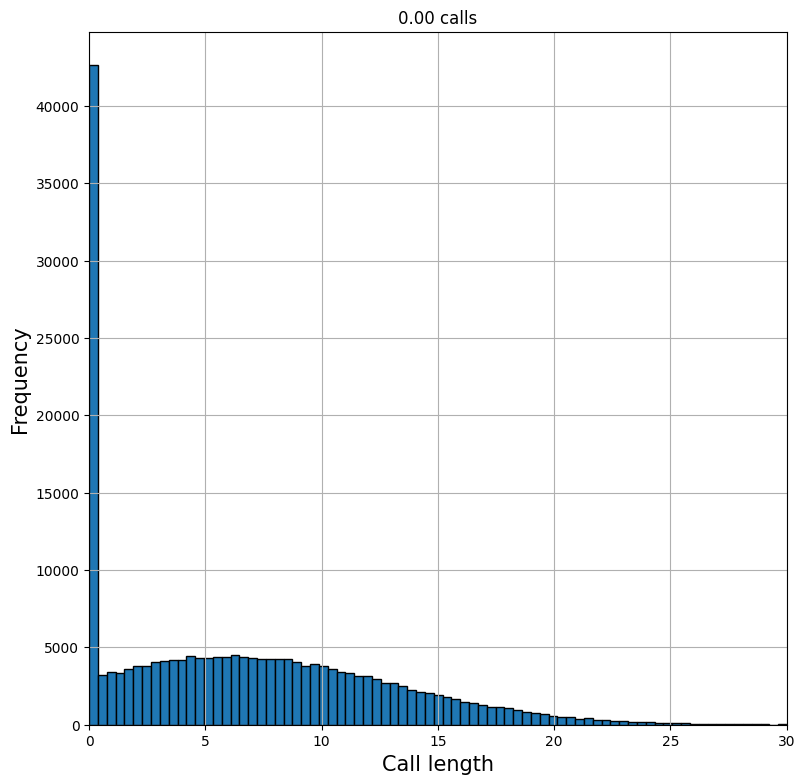

In [19]:
# hist visualisation of 0 00 calls
calls['duration'].plot(kind='hist', ec='black',  bins=100, figsize=(9, 9), grid=True)
plt.xlabel('Call length', fontsize=15)
plt.ylabel('Frequency', fontsize=15)
plt.xlim([0, 30])
plt.title('0.00 calls')
plt.show()


There are too many zero values, they will affect the average value and results in further analysis. Moreover, the operator will not receive any revenue for calls with a duration of 0.00 minutes, so I delete such values from the table

In [20]:
# renoving 0 00 values from the table
calls['duration'] = calls['duration'].replace(0, np.NaN)
calls = calls.dropna()


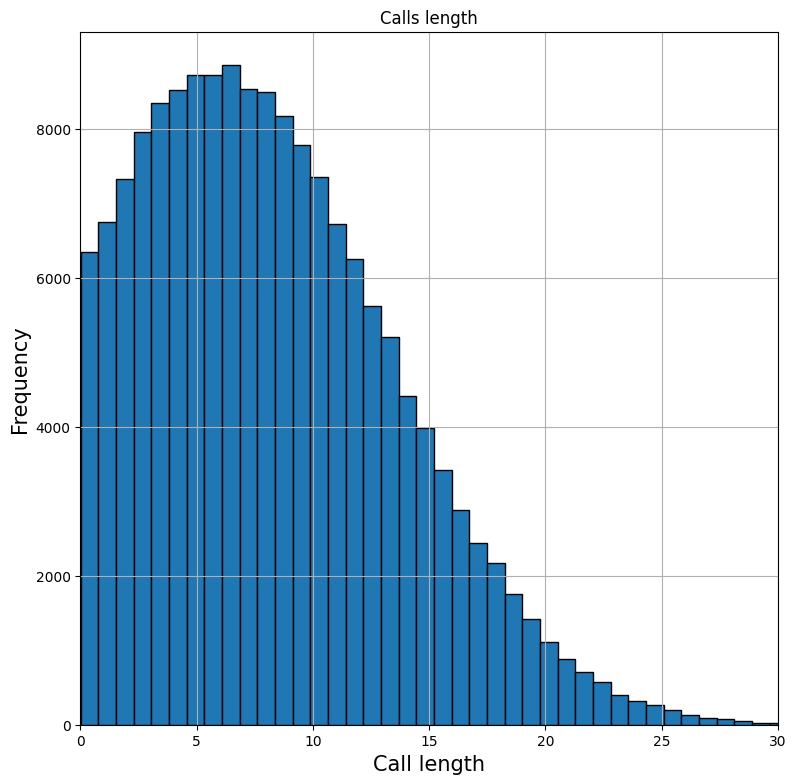

In [21]:
# checking the hist visualisation 
calls['duration'].plot(kind='hist', ec='black', bins=50, figsize=(9, 9), grid=True)
plt.xlabel('Call length', fontsize=15)
plt.ylabel('Frequency', fontsize=15)
plt.xlim([0, 30])
plt.title('Calls length')
plt.show()


There are no zeros that stand out from the overall distribution, but there are many near-zero values. To understand what is happening, I check the minimum value in the column.

In [22]:
# checking the minimal value in the column
calls['duration'].min()

0.01


Since we know that the operator will round up values like 0.01 to a minute, we round up all values in the column to an integer and change the data type so there is no floating point.

In [97]:
# rounding up and changing the data type
calls['duration'] = calls['duration'].apply(np.ceil).astype(int)

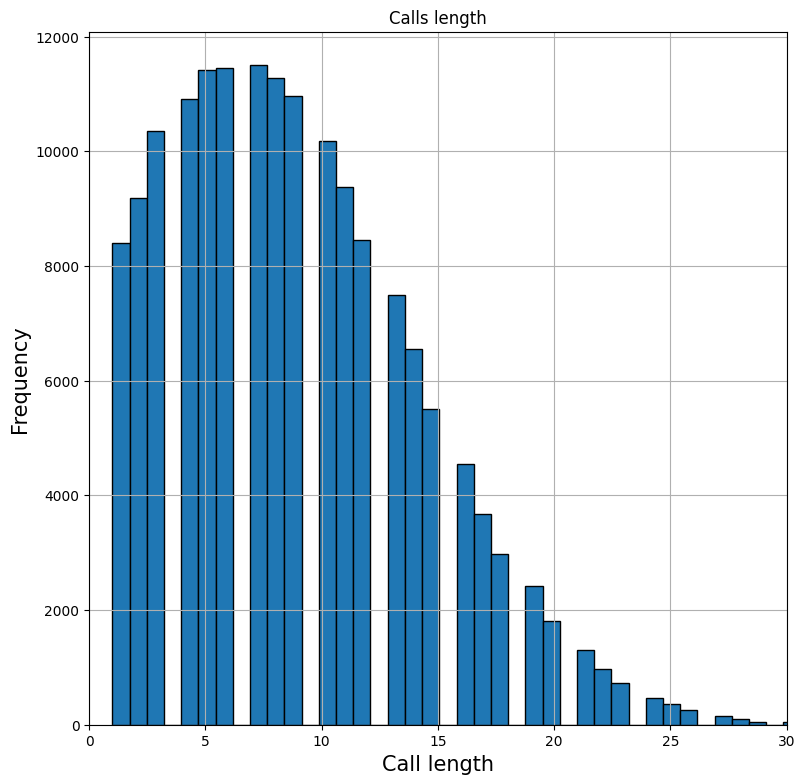

In [98]:
# now cheking the looks again
calls['duration'].plot(kind='hist', ec='black', bins=50, figsize=(9, 9), grid=True)
plt.xlabel('Call length', fontsize=15)
plt.ylabel('Frequency', fontsize=15)
plt.xlim([0, 30])
plt.title('Calls length')
plt.show()

The histogram shows that there are no calls with a duration of 0 or close to 0.

## Messages 

The `messages` table contains information about calls - id, quantity, date, etc:


In [25]:
# checking table info
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


The index and the number of rows in each column match - there are no missing values.

In [26]:
# visual check
messages.sample(10)

,id,message_date,user_id
90582,1375_382,2018-03-13,1375
45819,1197_149,2018-06-18,1197
42481,1183_124,2018-12-27,1183
97354,1399_56,2018-11-13,1399
107011,1431_753,2018-08-27,1431
72938,1309_74,2018-11-18,1309
102588,1418_6,2018-10-28,1418
25465,1104_657,2018-07-09,1104
59611,1262_102,2018-06-05,1262
95941,1393_515,2018-08-01,1393


In [27]:
# checking for duplicates
messages.duplicated().sum()

0

From the information about the table, I see that `message_date` has a data type `object`, which needs to be replaced with `datetime`:


In [99]:
# changing data type from  object to datetime:
messages['message_date'] = pd.to_datetime(messages['message_date'], format="%Y-%m-%d")

## Internet

Таблица `internet` содержит информация о объемах интернет траффика, которые использовали клиенты - id, дату сессии, количество трафика в мб и т.д:

In [29]:
# проверяем информацию о таблице
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


Индекс и количество строк в каждом столбце совпадают - пропусков нет.

In [30]:
# проверяем визуально
internet.sample(10)

,Unnamed: 0,id,mb_used,session_date,user_id
143925,143925,1481_279,639.39,2018-08-17,1481
7876,7876,1027_203,238.33,2018-10-16,1027
21094,21094,1071_211,220.13,2018-07-17,1071
147193,147193,1492_143,128.90,2018-11-30,1492
125804,125804,1423_261,129.08,2018-08-29,1423
95056,95056,1321_320,470.63,2018-04-06,1321
10894,10894,1037_51,637.15,2018-11-12,1037
47187,47187,1161_207,250.35,2018-09-02,1161
33199,33199,1116_240,593.62,2018-07-29,1116
94182,94182,1318_196,380.43,2018-07-31,1318


In [31]:
#проверяю наличие дублей
internet.duplicated().sum()

0

Из информации о таблице вижу, что `session_date` имеет тип даннхы `object`, который необходимо заменить на `datetime`:

In [32]:
# меняю тип данных с  object на datetime:
internet['session_date'] = pd.to_datetime(internet['session_date'], format="%Y-%m-%d")

Проверяю таблицу на количество интернет сессий с 0.00 мб скачанных данных. 

Отсутсвие траффика при подключении значит, что сессия по каким-то причинам оборвалась сразу же после подключения или клиент не смог подключиться. Сессии с количеством 0.00 мб не могут быть сессиями, в которых было скачано менее 1 мб данных (помним про округление вверх). Чтобы решить, что с ними делать, смотрю на количество таких сессий и как это будет выглядеть на гистограмме (так нагляднее).

In [33]:
#общее количество сессий 
internet.query('mb_used == 0.0').count()

Unnamed: 0      19598
id              19598
mb_used         19598
session_date    19598
user_id         19598
dtype: int64

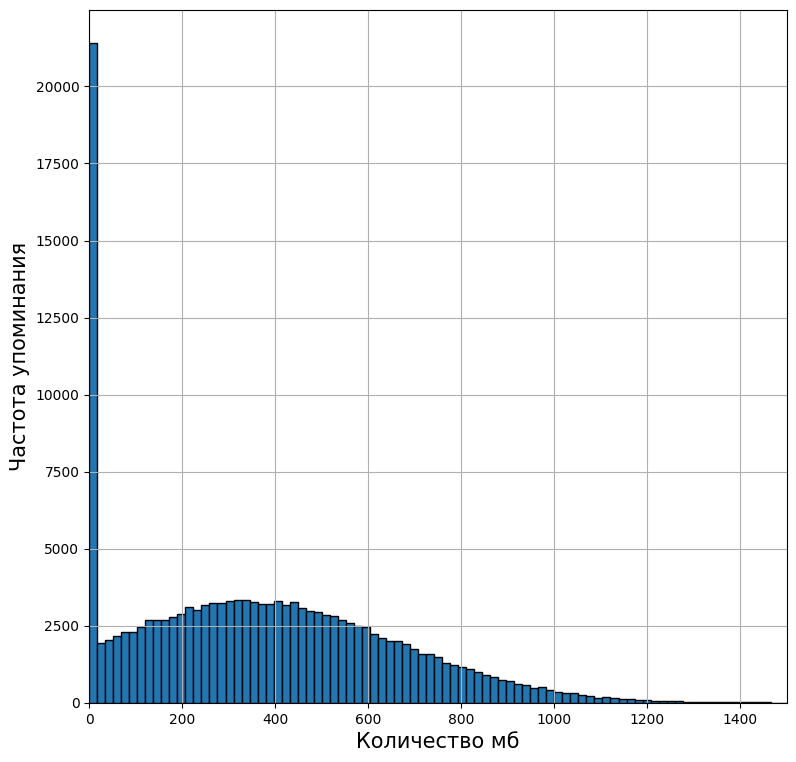

In [34]:
# смотрю как это выглядит на гистограмме
internet['mb_used'].plot(kind='hist', ec='black', bins=100, figsize=(9, 9), grid=True)
plt.xlabel('Количество мб', fontsize=15)
plt.ylabel('Частота упоминания', fontsize=15)
plt.xlim([0, 1500])
plt.show()

Нулевых значений слишком много, при дальнейшем анализе они будут влиять на среднее значение и результаты. К тому же, за сессии с 0.00 мб трафика оператор не получит никакой выручки, поэтому такие значения я удаляю из таблицы, а остальное округляю вверх.

In [35]:
# округляем и меняем тип данных
internet['mb_used'] = internet['mb_used'].apply(np.ceil).astype(int)

In [36]:
# удаляю нулевые значения из таблицы
internet['mb_used'] = internet['mb_used'].replace(0, np.NaN)
internet = internet.dropna()

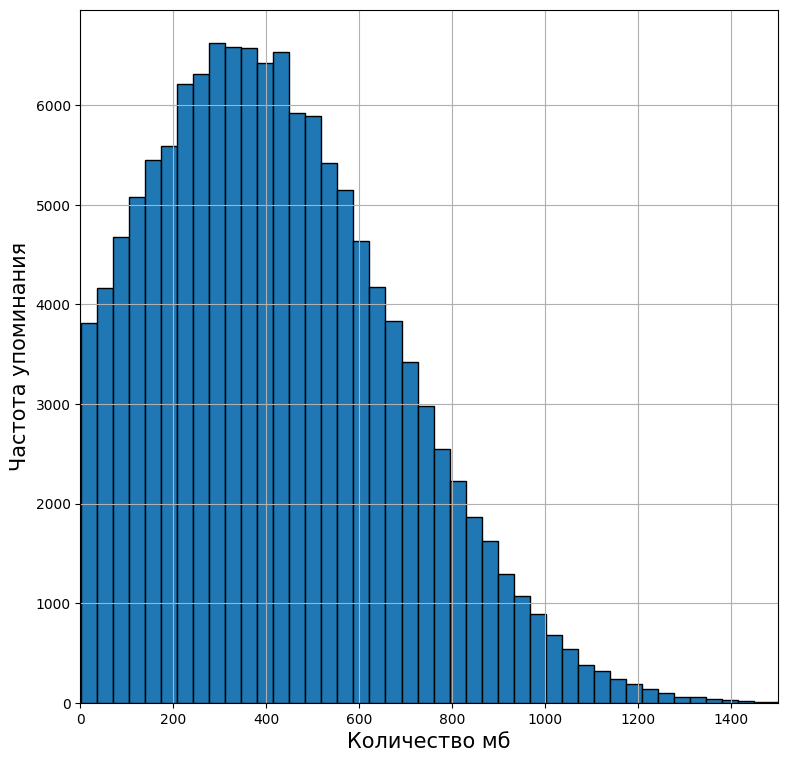

In [37]:
# смотрю как это выглядит на гистограмме
internet['mb_used'].plot(kind='hist', ec='black', bins=50, figsize=(9, 9), grid=True)
plt.xlabel('Количество мб', fontsize=15)
plt.ylabel('Частота упоминания', fontsize=15)
plt.xlim([0, 1500])
plt.show()

Выбивающихся из общего распределения нулей нет, но много около нулевых значений. Чтобы понять, что происходит проверяю минимальное значение в столбце:

In [38]:
# проверяю не равно ли минимальное значение 0
internet['mb_used'].min()

1.0

## <a name="tariffs-info">Tariffs (информация о тарифах)</a>

Информация о двух тарифах:

In [39]:
# проверяем информацию о датасете
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


In [40]:
# проверяем визуально
tariffs.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [41]:
# меняю название столбца, чтобы проще было объединять таблицы
tariffs.columns =['messages_included', 'mb_per_month_included', 'minutes_included', 'rub_monthly_fee', 'rub_per_gb', 'rub_per_message', 'rub_per_minute', 'tariff']

**Вывод:** Данные подготовленны к обработке, удалены пропуски и выбросы, исправленны типы данных, устранены прочие недочеты которые могли бы исказить результаты анализа.

# <a name="clients-calculations">Рассчеты использования тарифов клиентами (по месяцам)</a>

## <a name="calls-info-02">Calls (информация о звонках)</a>

Сколько минут разговора требуется клиентам каждого тарифа в месяц. 


In [42]:
# Добавляю стобец с месяцем
calls['month'] = pd.DatetimeIndex(calls['call_date']).month


In [43]:
# создаю новую таблицу количеством и длительностью звонков для каждого клиента по месяцам
calls_month = pd.pivot_table(calls, index=['user_id','month'],
                                    values=['duration','id'],
                                    aggfunc={'duration':sum,'id':'count'}
                             ).reset_index()
# меняем название столбцов
calls_month.columns =['user_id', 'month', 'duration', 'calls_amount']

#проверяем результат
calls_month.sample(10)

,user_id,month,duration,calls_amount
2932,1463,11,248,25
1042,1168,5,1232,142
614,1098,11,540,58
163,1025,5,552,59
336,1054,8,605,68
2443,1388,11,506,57
773,1123,5,546,59
1541,1247,10,361,47
2555,1403,9,65,9
2559,1404,4,105,13


## <a name="messages-info-02">Messages (информация о sms сообщениях)</a>

Количество отправленных сообщений по месяцам.

In [44]:
# Добавляю стобец с месяцем 
messages['month'] = pd.DatetimeIndex(messages['message_date']).month


In [45]:
# создаю новую таблицу количеством сообщений для каждого клиента по месяцам
messages_month = pd.pivot_table(messages, index=['user_id','month'],
                                          values='id',
                                          aggfunc='count'
                                ).reset_index()

# меняем название столбцов
messages_month.columns =['user_id', 'month', 'messages_amount']

#проверяем результат
messages_month.sample(10)

,user_id,month,messages_amount
746,1142,8,43
763,1145,7,111
2313,1426,12,69
137,1025,8,28
2358,1433,12,97
537,1098,6,5
2568,1475,2,20
885,1168,10,38
742,1142,4,24
2517,1465,9,53


## <a name="internet-info-02">Internet (информация об использовании интернета)</a>

Количество трафика по месяцам.

In [46]:
# Добавляю стобец с месяцем
internet['month'] = pd.DatetimeIndex(internet['session_date']).month


In [47]:
# создаю новую таблицу количеством сообщений для каждого клиента по месяцам
internet_month = pd.pivot_table(internet, index=['user_id','month'],
                                          values='mb_used',
                                          aggfunc='sum'
                                ).reset_index()


#проверяем результат
internet_month.sample(10)

,user_id,month,mb_used
3103,1482,5,12464.0
29,1004,12,18038.0
2163,1341,11,31224.0
2397,1378,11,10476.0
2966,1464,12,31600.0
1277,1200,5,18717.0
1107,1174,10,19151.0
3114,1483,7,14167.0
1244,1193,9,11353.0
2299,1366,6,4746.0


<div class="alert alert-success">
<h2> Комментарий ревьюера </h2>

Показатели рассчитаны. Данные подготовлены к дальнейшим расчетам.

</div>

## <a name="clients-meged">Сводная таблица с рассчетами</a>

Объединяю все таблицы в одну, для того чтобы проще было подсчитать доход от клиента в месяц.

In [48]:
# объединяю данные из таблиц звонков и интернета
clients_total = calls_month.merge(internet_month, on=['user_id','month'], how ='outer')

# добавляю данные из таблицы с сообщениями
clients_total = clients_total.merge(messages_month, on=['user_id','month'], how ='outer')


# добавляю информацию о клиентах
clients_total = clients_total.merge(users[['user_id','tariff', 'city']], on='user_id', how ='left')

#добавляю информацию о тарифах
clients_total = clients_total.merge(tariffs, on='tariff', how='left')

# проверяю результат
clients_total.sample(10)

,user_id,month,duration,calls_amount,mb_used,messages_amount,tariff,city,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
557,1089,3,626.0,70.0,17513.0,155.0,ultra,Иркутск,1000,30720,3000,1950,150,1,1
2169,1346,12,869.0,111.0,4700.0,50.0,ultra,Саратов,1000,30720,3000,1950,150,1,1
2534,1401,6,463.0,53.0,9687.0,32.0,smart,Москва,50,15360,500,550,200,3,3
996,1158,10,468.0,53.0,15544.0,62.0,smart,Новокузнецк,50,15360,500,550,200,3,3
589,1094,10,868.0,91.0,17755.0,28.0,ultra,Новосибирск,1000,30720,3000,1950,150,1,1
1600,1256,10,662.0,74.0,22225.0,103.0,smart,Санкт-Петербург,50,15360,500,550,200,3,3
3120,1491,7,606.0,67.0,20916.0,58.0,ultra,Челябинск,1000,30720,3000,1950,150,1,1
2249,1360,12,825.0,98.0,7523.0,NaN,ultra,Санкт-Петербург,1000,30720,3000,1950,150,1,1
2212,1356,6,741.0,80.0,39967.0,158.0,ultra,Москва,1000,30720,3000,1950,150,1,1
3208,1476,4,NaN,NaN,531.0,NaN,ultra,Москва,1000,30720,3000,1950,150,1,1


<div class="alert alert-success">
<h2> Комментарий ревьюера </h2>

Да, именно внешнее соединение нам и нужно в данном случае. Иначе в таблицу не попадут клиенты, которые не пользовались одним из видов услуг оператора в течение конкретного месяца. 

</div>

Вижу, что есть пропуски, проверяю сколько их.

In [49]:
# информация о таблице
clients_total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   user_id                3214 non-null   int64  
 1   month                  3214 non-null   int64  
 2   duration               3168 non-null   float64
 3   calls_amount           3168 non-null   float64
 4   mb_used                3201 non-null   float64
 5   messages_amount        2717 non-null   float64
 6   tariff                 3214 non-null   object 
 7   city                   3214 non-null   object 
 8   messages_included      3214 non-null   int64  
 9   mb_per_month_included  3214 non-null   int64  
 10  minutes_included       3214 non-null   int64  
 11  rub_monthly_fee        3214 non-null   int64  
 12  rub_per_gb             3214 non-null   int64  
 13  rub_per_message        3214 non-null   int64  
 14  rub_per_minute         3214 non-null   int64  
dtypes: f

Пропуски есть, видимо какие-то клиенты использовали тариф только для того, чтобы звонить, поэтому у них нет использованного трафика и так далее. Посмотрим количество пропусков в каждом столбце.

In [50]:
pd.DataFrame(round((clients_total.isna().mean()*100),2)).style.background_gradient('coolwarm')

,0
user_id,0.000000
month,0.000000
duration,1.430000
calls_amount,1.430000
mb_used,0.400000
messages_amount,15.460000
tariff,0.000000
city,0.000000
messages_included,0.000000
mb_per_month_included,0.000000


15% - много, поэтому в 'messages_amount' я заменяю пропуски на 0, а остальные удаляю.

In [51]:
# заменяю пропуски на 0
clients_total['messages_amount'].fillna(0, inplace=True)

# удаляю там, где можно удалить
clients_total.dropna(subset=['duration', 'calls_amount', 'mb_used'], inplace=True)

# проверяю результат
clients_total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3155 entries, 0 to 3167
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   user_id                3155 non-null   int64  
 1   month                  3155 non-null   int64  
 2   duration               3155 non-null   float64
 3   calls_amount           3155 non-null   float64
 4   mb_used                3155 non-null   float64
 5   messages_amount        3155 non-null   float64
 6   tariff                 3155 non-null   object 
 7   city                   3155 non-null   object 
 8   messages_included      3155 non-null   int64  
 9   mb_per_month_included  3155 non-null   int64  
 10  minutes_included       3155 non-null   int64  
 11  rub_monthly_fee        3155 non-null   int64  
 12  rub_per_gb             3155 non-null   int64  
 13  rub_per_message        3155 non-null   int64  
 14  rub_per_minute         3155 non-null   int64  
dtypes: f

<div class="alert alert-success">
<h2> Комментарий ревьюера </h2>

Исходя из высказанной тобой причины появления пропусков, можно их все обработать 0. Однако удалено не так много данных, так что твой вариант вполне приемлем. 

</div>

In [52]:
#проверяю наличие дублей
clients_total.duplicated().sum()

0

Таблица готова к дальнейшему анализу и вычислениям. 

Рассчитаем помесячную выручку с каждого клиента и добавим результат в отдельный столбец. 

In [53]:
# функция для подсчета затрат сверх тарифа

def extra_expenses(row):
    ex_minutes = (row['calls_amount'] - row['minutes_included']) * row['rub_per_minute']
    ex_gb = (row['mb_used'] - row['mb_per_month_included']) * row['rub_per_gb'] / 1024
    ex_messages = (row['messages_amount'] - row['messages_included']) * row['rub_per_message']
    extra = 0
    for y in [ex_minutes, ex_gb, ex_messages]:
              if y > 0:
                extra +=y
    return extra
    

In [54]:
# добавляем результат в отдельный столбец
clients_total['extra_expenses'] = clients_total.apply(lambda x: extra_expenses(x), axis=1)

In [55]:
# считаем общую выручку и проверяем результат
clients_total['income'] = clients_total['extra_expenses'] + clients_total['rub_monthly_fee']
clients_total['income'] = clients_total['income'].astype(int)
clients_total.sample(10)


,user_id,month,duration,calls_amount,mb_used,messages_amount,tariff,city,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,extra_expenses,income
2179,1350,11,478.0,48.0,18533.0,60.0,ultra,Омск,1000,30720,3000,1950,150,1,1,0.000000,1950
43,1006,3,286.0,36.0,17309.0,0.0,smart,Ульяновск,50,15360,500,550,200,3,3,380.664062,930
2149,1344,5,762.0,92.0,22839.0,124.0,ultra,Воронеж,1000,30720,3000,1950,150,1,1,0.000000,1950
315,1051,5,59.0,8.0,1843.0,0.0,smart,Москва,50,15360,500,550,200,3,3,0.000000,550
675,1109,6,382.0,47.0,14669.0,0.0,smart,Санкт-Петербург,50,15360,500,550,200,3,3,0.000000,550
2109,1337,12,94.0,11.0,22054.0,14.0,smart,Вологда,50,15360,500,550,200,3,3,1307.421875,1857
1237,1196,6,1410.0,149.0,22677.0,153.0,ultra,Воронеж,1000,30720,3000,1950,150,1,1,0.000000,1950
307,1049,10,586.0,71.0,3350.0,0.0,ultra,Москва,1000,30720,3000,1950,150,1,1,0.000000,1950
372,1058,12,701.0,81.0,16651.0,29.0,smart,Вологда,50,15360,500,550,200,3,3,252.148438,802
2306,1372,5,478.0,52.0,11519.0,43.0,smart,Магнитогорск,50,15360,500,550,200,3,3,0.000000,550


<div class="alert alert-success">
<h2> Комментарий ревьюера </h2>

Финальная таблица получена верным образом. Стоит убрать из нее излишнюю информацию о тарифах. Она у нас уже есть в таблице tariffs. Дублировать ее не стоит.

</div>

# <a name="smart-ultra-calculations"> Исследовательский анализ тарифов</a>

Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц?

Для удобства создам отдельные таблицы по тарифам.

In [56]:
# создаю две отдельные таблицы по тарифам
smart = clients_total[clients_total['tariff'] == 'smart']
ultra = clients_total[clients_total['tariff'] == 'ultra']

## <a name="calls-info-03">Calls (информация о звонках)</a>

Смотрю информацию по минутам разговора для тарифа Ultra.

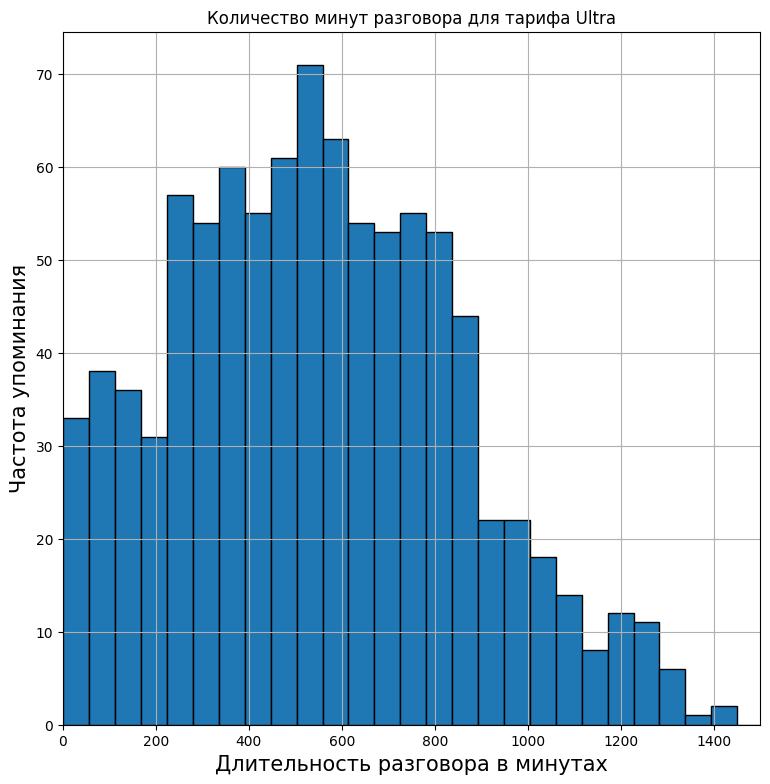

In [57]:
# график количества минут разговоров
ultra['duration'].plot(kind='hist', ec='black', bins=30, figsize=(9, 9), grid=True)
plt.xlabel('Длительность разговора в минутах', fontsize=15)
plt.ylabel('Частота упоминания', fontsize=15)
plt.xlim([0, 1500])
plt.title("Количество минут разговора для тарифа Ultra")
plt.show()



In [58]:
# статистические данные по столбцу
ultra['duration'].describe()

count     936.000000
mean      551.708333
std       304.979493
min         1.000000
25%       319.500000
50%       533.000000
75%       760.250000
max      1673.000000
Name: duration, dtype: float64

In [59]:
# общее количество минут
ultra['duration'].sum()

516399.0

Общая продолжительность звонков на тарифе Ultra - 516399 минут. В среднем клиенты используют 551 минуту голоса в месяц. Учитывая, что включенных и предоплаченнх минут в тарифе Ultra - 3000, а максимальное значение длительности разговора - 1673, можно сделать вывод, что если клиенты и выходят за предоплаченный лимит - это случается очень редко и в виде исключения.

Смотрю как выглядят минуты разговора для тарифа Smart.

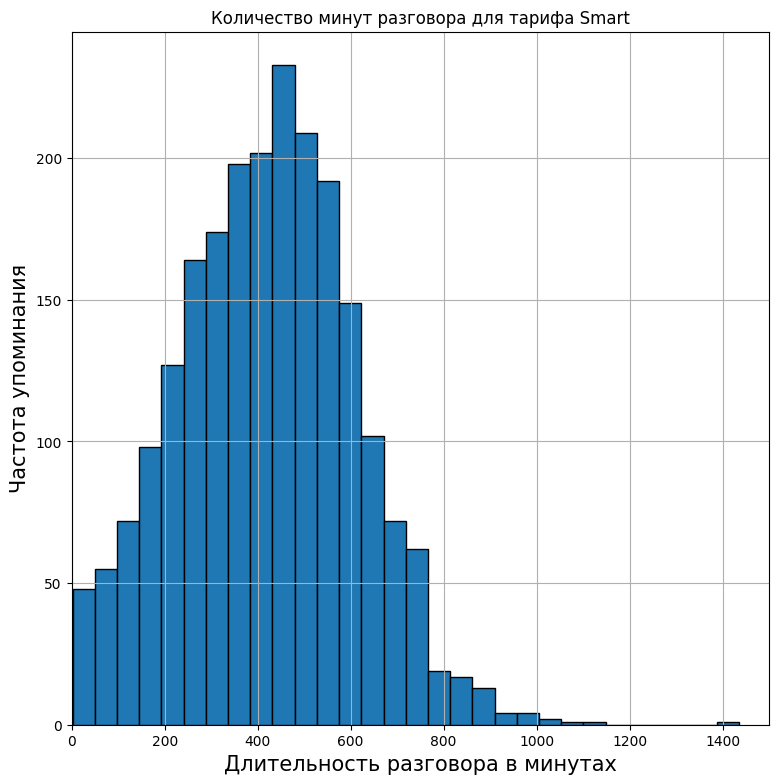

In [60]:
# график количества минут разговоров
smart['duration'].plot(kind='hist', ec='black', bins=30, figsize=(9, 9), grid=True)
plt.xlabel('Длительность разговора в минутах', fontsize=15)
plt.ylabel('Частота упоминания', fontsize=15)
plt.xlim([0, 1500])
plt.title("Количество минут разговора для тарифа Smart")
plt.show()

In [61]:
# статистические данные по столбцу
smart['duration'].describe()

count    2219.000000
mean      419.776476
std       188.745325
min         2.000000
25%       285.500000
50%       423.000000
75%       546.000000
max      1435.000000
Name: duration, dtype: float64

In [62]:
# общее количество минут
smart['duration'].sum()

931484.0

Общая продолжительность звонков на тарифе Smart - 931484 минут. В среднем клиенты используют 419 минут голоса в месяц. Учитывая, что включенных и предоплаченнх минут в тарифе Smart - 500, а максимальное значение 1673, можно сделать вывод, что клиенты тарифа или очень близки к лимиту предоплаченных минут или довольно часто выходят за предоплаченный лимит.

In [63]:
# проверяем количество клиентов превыисивших предоплаченны лимит
smart.query('duration>500').count()

user_id                  754
month                    754
duration                 754
calls_amount             754
mb_used                  754
messages_amount          754
tariff                   754
city                     754
messages_included        754
mb_per_month_included    754
minutes_included         754
rub_monthly_fee          754
rub_per_gb               754
rub_per_message          754
rub_per_minute           754
extra_expenses           754
income                   754
dtype: int64

Клиентов, превышающих предоплаченный лимит - около 33%  от общего числа клиентов, пользующихся тарифом Smart.

Собираю всю информацию по звонкам в одну таблицу, добавляю стандартное отклонение и дисперсию:

In [64]:
# таблица с данными о среднем, медианном, стандартном отклонении и дисперсии
clients_total.groupby('tariff')\
     .agg({'duration':['median','mean','var','std']})\
     .style.format("{:.1f}")

## <a name="internet-info-03">Internet (информация об использовании интернета)</a>

Смотрю информацию по объему трафика для тарифа Ultra.

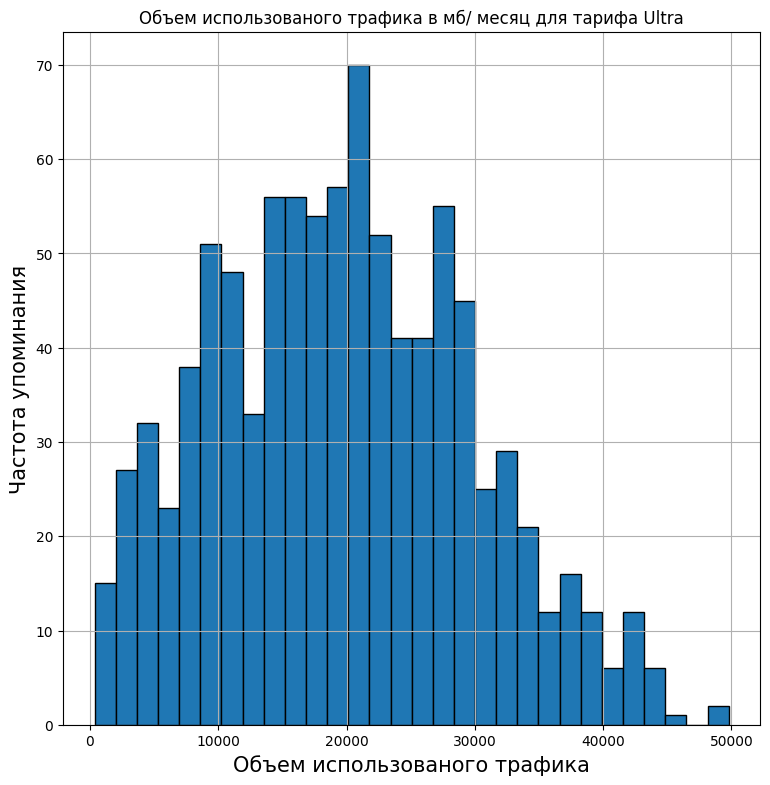

In [65]:
# график по объему трафика разговоров
ultra['mb_used'].plot(kind='hist', ec='black', bins=30, figsize=(9, 9), grid=True)
plt.xlabel('Объем использованого трафика', fontsize=15)
plt.ylabel('Частота упоминания', fontsize=15)
plt.title("Объем использованого трафика в мб/ месяц для тарифа Ultra")
plt.show()

In [66]:
# статистические данные по столбцу
ultra['mb_used'].describe()

count      936.000000
mean     19718.717949
std       9972.317787
min        366.000000
25%      11917.000000
50%      19445.000000
75%      26958.500000
max      49789.000000
Name: mb_used, dtype: float64

In [67]:
# общее количество мб
ultra['mb_used'].sum()

18456720.0

Общее количество трафика на тарифе Ultra -  18440066 мб. В среднем клиенты используют 19700 мб трафика в месяц. Учитывая, что включенных и предоплаченнх мб в тарифе Ultra - 30720, а максимальное значение использования трафика - 49746 мб, можно сделать вывод, что существуют клиенты, которые выходят за пределы предоплаченного количества. 

In [68]:
# проверяем количество клиентов первысивших лимит
ultra.query('mb_used > 30720').count()

user_id                  128
month                    128
duration                 128
calls_amount             128
mb_used                  128
messages_amount          128
tariff                   128
city                     128
messages_included        128
mb_per_month_included    128
minutes_included         128
rub_monthly_fee          128
rub_per_gb               128
rub_per_message          128
rub_per_minute           128
extra_expenses           128
income                   128
dtype: int64

Всего таких клиентов около 13% от общего числа клиентов, пользующихся тарифом Ultra.

Смотрю информацию по объему трафика для тарифа Smart.

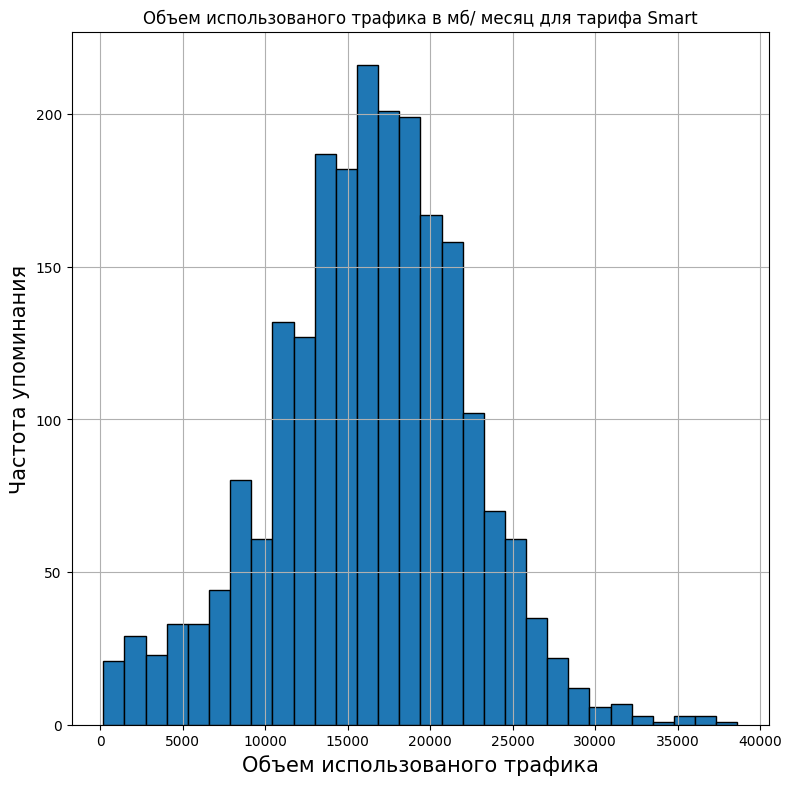

In [69]:
# график по объему трафика разговоров
smart['mb_used'].plot(kind='hist', ec='black', bins=30, figsize=(9, 9), grid=True)
plt.xlabel('Объем использованого трафика', fontsize=15)
plt.ylabel('Частота упоминания', fontsize=15)
#plt.xlim([0, 1500])
#plt.xlim([0, 1500])
plt.title("Объем использованого трафика в мб/ месяц для тарифа Smart")
plt.show()

In [70]:
# статистические данные по столбцу
smart['mb_used'].describe()

count     2219.000000
mean     16246.091933
std       5865.865927
min        202.000000
25%      12686.500000
50%      16531.000000
75%      20074.000000
max      38610.000000
Name: mb_used, dtype: float64

In [71]:
# общее количество мб
smart['mb_used'].sum()

36050078.0

Общее количество трафика на тарифе Smart - 36004953 мб. В среднем клиенты используют 16225 мб трафика в месяц. Учитывая, что включенных и предоплаченнх мб в тарифе Smart - 15360, а максимальное значение использования трафика - 38553 мб, можно сделать вывод, что существуют клиенты, которые выходят за пределы предоплаченного количества. 

In [72]:
# проверяем количество клиентов первысивших лимит
smart.query('mb_used > 15360').count()

user_id                  1304
month                    1304
duration                 1304
calls_amount             1304
mb_used                  1304
messages_amount          1304
tariff                   1304
city                     1304
messages_included        1304
mb_per_month_included    1304
minutes_included         1304
rub_monthly_fee          1304
rub_per_gb               1304
rub_per_message          1304
rub_per_minute           1304
extra_expenses           1304
income                   1304
dtype: int64

Таких клиентов около 60%  от общего числа клиентов, пользующихся тарифом Smart.

Добавляю всю инофрмацию по трафику в одну таблицу, добавляю стандартное отклонение и дисперсию.

In [73]:
# таблица с данными о среднем, медианном, стандартном отклонении и дисперсии
clients_total.groupby('tariff')\
     .agg({'mb_used':['median','mean','var','std']})\
     .style.format("{:.1f}")

## <a name="messages-info-03">Messages (информация о sms сообщениях)</a>

Смотрю информацию по объему сообщений для тарифа Ultra.

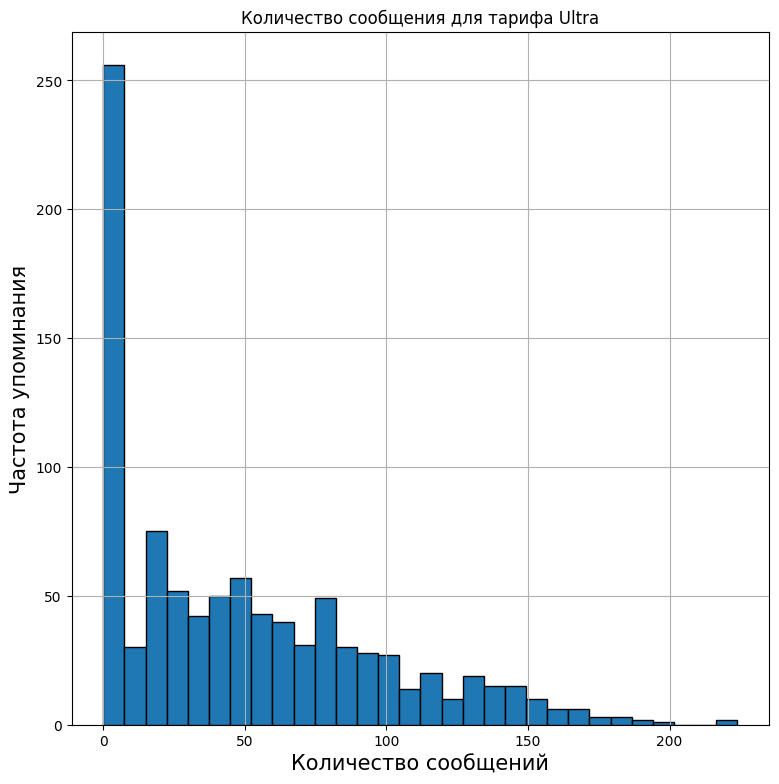

In [74]:
# график по количеству сообщений
ultra['messages_amount'].plot(kind='hist', ec='black', bins=30, figsize=(9, 9), grid=True)
plt.xlabel('Количество сообщений', fontsize=15)
plt.ylabel('Частота упоминания', fontsize=15)
plt.title("Количество сообщения для тарифа Ultra")
plt.show()

In [75]:
# статистические данные по столбцу
ultra['messages_amount'].describe()

count    936.000000
mean      49.033120
std       46.778211
min        0.000000
25%        5.000000
50%       39.500000
75%       79.000000
max      224.000000
Name: messages_amount, dtype: float64

В столбце довольно много 0, видимо многие клиенты пользуются только звонками или обмениваются сообщениями в мессенджерах, а значит больше тратят на интернет. Чтобы понять, насолько близко среднее значение к истине, посмотрим еще на медиану, которая более устойчива к выбросам.

In [76]:
# проверяем медиану
ultra['messages_amount'].median()

39.5

Получается разница примерно в 10 сообщений/ клиент. С моей точки зрения - это довольно большая разница, которая может повлиять на выручку. Поэтому для анализа я буду использовать более устойчивую к выбросам медиану.

In [77]:
# общее количество сообщений
ultra['messages_amount'].sum()

45895.0

Общее количество сообщений на тарифе Ultra - 45895. В среднем клиенты посылают около 40 сообщений в месяц. Учитывая, что включенных и предоплаченнх сообщений в тарифе Ultra - 1000, а максимальное значение отправленных сообщений - 224, можно сделать вывод, что клиенты редко выходят за предоплаченный лимит сообщений.

Смотрю информацию по объему сообщений для тарифа Smart.

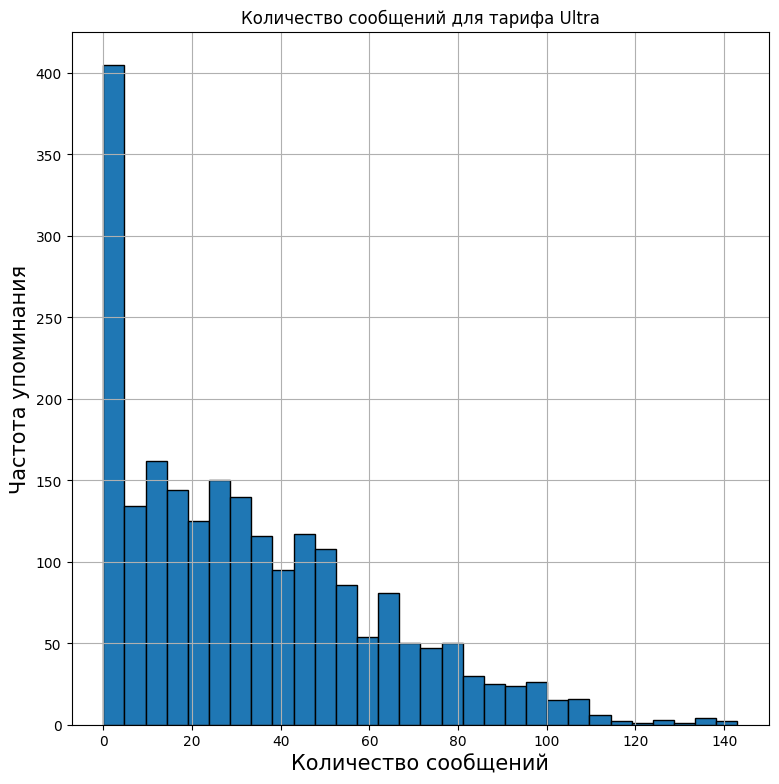

In [78]:
# график по количеству сообщений
smart['messages_amount'].plot(kind='hist', ec='black', bins=30, figsize=(9, 9), grid=True)
plt.xlabel('Количество сообщений', fontsize=15)
plt.ylabel('Частота упоминания', fontsize=15)
#plt.xlim([0, 1500])
#plt.xlim([0, 1500])
plt.title("Количество сообщений для тарифа Ultra")
plt.show()

In [79]:
# статистические данные по столбцу
smart['messages_amount'].describe()

count    2219.000000
mean       33.421361
std        28.266229
min         0.000000
25%        10.000000
50%        28.000000
75%        51.000000
max       143.000000
Name: messages_amount, dtype: float64

<div class="alert alert-danger">
<h2> Комментарий ревьюера </h2>

Также в задании просят рассчитать и дисперсию по каждому параметру. Дополни таблицы по стат. показателям по всем услугам. 

</div>


<div class="alert alert-success">
<h2> Комментарий ревьюера </h2>

Будет здорово, если все стат. показатели ты соберешь в единую таблицу. Так нам будет заметно удобнее сравнивать тарифы между собой. 

</div>


<div class="alert alert-info" role="alert">
Добавила таблицы с дисперсией, стандартным отклонением и пр. данными по двум тарифам в каждый раздел.
Данные по сообщениям ниже, в конце этого раздела.
</div>

Ситуация со средним значением и медианой такая же, как и у тарифа Ultra. Посмотрим, насколько велика разница.

In [80]:
# проверяем медиану
smart['messages_amount'].median()

28.0

Разница около 3 сообщений, думаю это не очень большая разница и можно использовать как среднее значение, так и медиану.

In [81]:
# общее количество сообщений
smart['messages_amount'].sum()

74162.0

Общее количество сообщений на тарифе Ultra - 74162. В среднем клиенты посылают около 30 сообщений в месяц. Учитывая, что включенных и предоплаченнх сообщений в тарифе Ultra - 50, а максимальное значение отправленных сообщений - 143, можно сделать вывод, что часть клиентов превышает лимит. 

In [82]:
# проверяем количество клиентов первысивших лимит
smart.query('messages_amount > 50').count()

user_id                  564
month                    564
duration                 564
calls_amount             564
mb_used                  564
messages_amount          564
tariff                   564
city                     564
messages_included        564
mb_per_month_included    564
minutes_included         564
rub_monthly_fee          564
rub_per_gb               564
rub_per_message          564
rub_per_minute           564
extra_expenses           564
income                   564
dtype: int64

Таких клиентов около 25% от общего числа клиентов, пользующихся тарифом Smart.

Соберем все показатели по сообщениям в одну таблицу, добавим стандартное отклонение и дисперсию.

In [83]:
# смотрим данные по сообщениям
clients_total.groupby('tariff')\
  .agg({'messages_amount':['median','mean','var','std']})\
  .style.format("{:.1f}")

<div class="alert alert-success">
<h2> Комментарий ревьюера 2</h2>

Отличная таблица 👍 

</div>

Общий вывод: клиенты тарифа Smart чаще выходят за предоплаченный лимит, если все собрать в одну таблицу и сравнить, получится следующее:

|Тариф/|св. тар. звонки|св. тар. интернет|св. тар. сообщения|
|----|----|----|----|
|Ultra|0% |13% |0% |
|Smart|33% |60% |25%|

<div class="alert alert-warning">
<h2> Комментарий ревьюера </h2>

Базовые статистические параметры получены. Приведены все необходимые графики. Графики для одинаковых услуг тарифов лучше привести на одном рисунке. Так удобнее будет сравнивать тарифы. Также можно привести график по выручке компании с разбиением по тарифу. 

</div>


<div class="alert alert-info" role="alert">
Я спросила у кураторов и тьюторов, мне ответили - что на одном графике или на разных - это вкусовщина. Мне удобнее на разных, если я сейчас все начну переделывать на один рисунок - мне это сломает структуру документа. И что значит "рисунок"? График? Два тарифа на одной гистограмме? Ничего не поняла :) Я не ругаюсь, если что, я правда не поняла что надо сделать...
</div>

<div class="alert alert-success">
<h2> Комментарий ревьюера 2</h2>

Две гистограммы по разным тарифам на одних осях. Вот так) Да, соглашусь, это вопрос удобства. Однако основная цель данного раздела - сравнить тарифы между собой. Лучше будет это сделать, когда гистограммы по услугам приведены на одном рисунке. 

</div>

# <a name="hyp-test-01">Проверка гипотез: средняя выручка</a>

Сравним дисперсии выборок, чтобы выбрать значение аргумента `equal_var`.

In [84]:
# таблица с данными о среднем, медианном, стандартном отклонении и дисперсии
clients_total.groupby('tariff')\
     .agg({'income':['var','std']})\
     .style.format("{:.1f}")

Различие значительное, значит 'equal_var' = False

Задача проверить гипотезу: средняя выручка пользователей тарифов Ultra и Smart различается.
    
* H0: выручка пользователей тарифов Ultra и Smart не различается
* H1: выручка пользователей тарифов Ultra и Smart различается

Так как две выборки независимы, использую Student t-test.

Сначала проверим данные о выручке на выбросы. С моей точки зрения, лучше всего для этого подходит boxplot.

<Axes: title={'center': 'income'}, xlabel='tariff'>

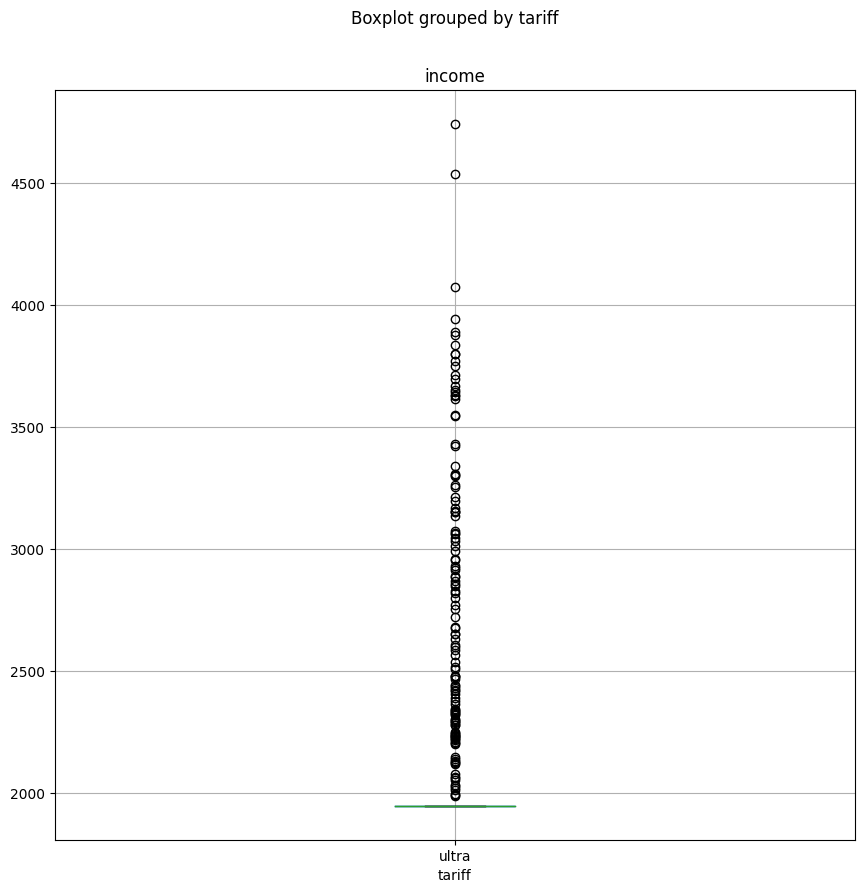

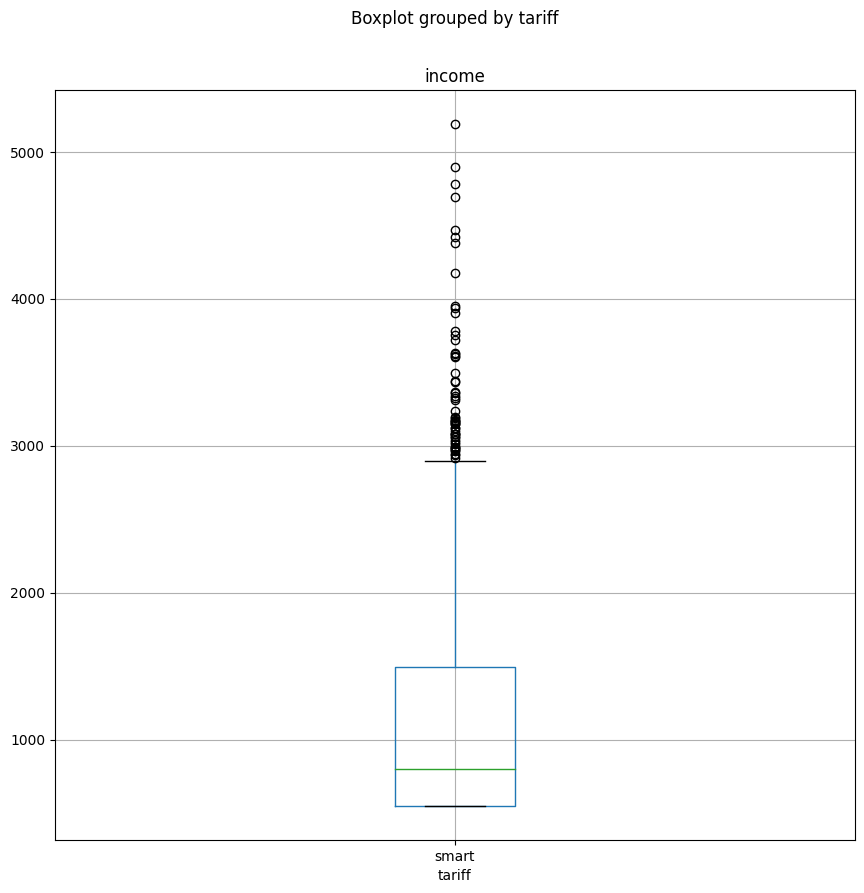

In [85]:
# строим графики чтобы увидеть есть ли выбросы
ultra.boxplot('income', by='tariff', figsize=(10,10))
smart.boxplot('income', by='tariff', figsize=(10,10))



Графики выглядят странно, но самое главное, видно, что есть выбросы, которые могут исказить данные. 

Для того, чтобы удалить выбросы, использую функцию, которая их определяет на основании квартилей и удаляет лишние данные.

In [86]:
# функция для поиска выбросов на 90% подсказанная разными людьми на stackoverflow, спасибо им
def remove_outlier(df, column, graf=0, x = 10, y = 10):
    # присваиваю переменным значение квартилей
    low_quartile = df[column].quantile(0.25)
    upper_quartile = df[column].quantile(0.75)
    inter_q_range = upper_quartile - low_quartile
    # использую Interquartile Rule to Find Outliers: https://www.thoughtco.com/what-is-the-interquartile-range-rule-3126244
    find_outlier = (df[column] >= (low_quartile - 1.5 * inter_q_range)) & (df[column] <= (upper_quartile + 1.5 * inter_q_range))
    if graf == 1:
        return df.loc[find_outlier].boxplot([column], figsize=(x,y))
    else:
        return df.loc[find_outlier]
    

In [87]:
# удаляем выбросы
ultra = remove_outlier(ultra, 'income', 0)
ultra_income = ultra['income']

smart = remove_outlier(smart, 'income', 0)
smart_income = smart['income']

<Axes: title={'center': 'income'}, xlabel='tariff'>

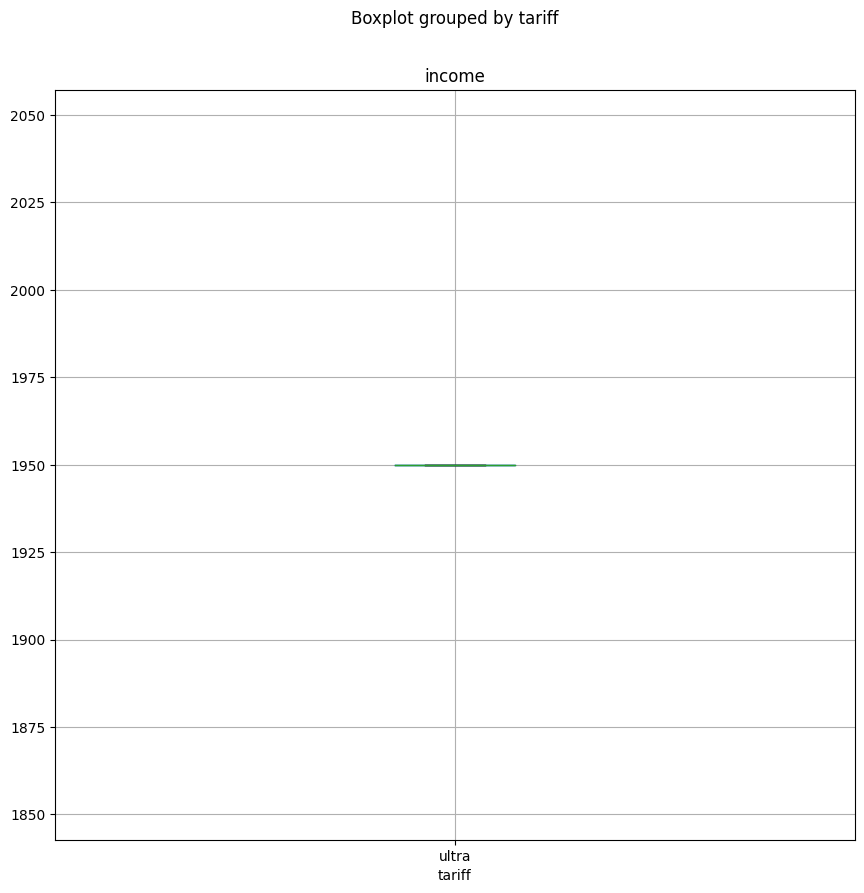

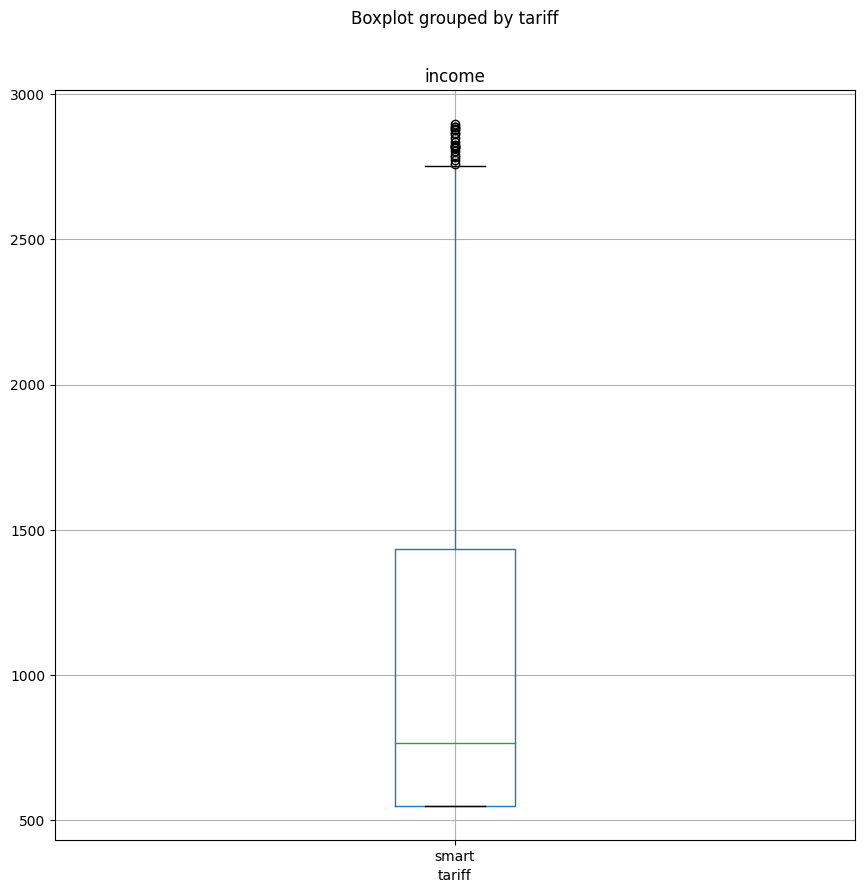

In [88]:
# проверяем результат
ultra.boxplot('income', by='tariff', figsize=(10,10))
smart.boxplot('income', by='tariff', figsize=(10,10))

Вроде выбросов меньше, можно приступать к проверке гипотезы.

In [89]:
#проверяем гипотезу
alpha = 0.05
result = st.ttest_ind(ultra_income, smart_income, equal_var=False)

if result.pvalue < alpha:
    print('p-value:', result.pvalue)
    print('Отвергаем H0')
else:
    print('p-value:', result.pvalue)
    print('Отвергаем H1')

p-value: 0.0
Отвергаем H0


<ipython-input-89-5f65e3994c15>:3: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  result = st.ttest_ind(ultra_income, smart_income, equal_var=False)


Значимость p-value очень мала, отвергаем нулевую гипотезу. 

Вывод: средняя выручка тарифов Smart и Ultra различается.

<div class="alert alert-success">
<h2> Комментарий ревьюера </h2>

Гипотезы сформулированы и проверены верно. pvalue стоит вывести полностью для понимания порядка данной величины. 

</div>

Из любопытства посчитаю выручку по тарифам:

In [90]:
clients_total.pivot_table(index='tariff', values='income', aggfunc=['sum','mean', 'median'])

,sum,mean,median
,income,income,income
tariff,,,
smart,2461788,1109.413249,796
ultra,1931146,2063.190171,1950


# <a name="hyp-test-02">Проверка гипотез: выручка по городам</a>

Задача проверить гипотезу: средняя выручка пользователей тарифов «Ультра» и «Смарт» различается.

* H0: выручка компании в Москве и других регионах одинаковая
* H1: выручка в Москве и других региона различается

Так как две выборки независимы, использую Student t-test.

In [91]:
# проверяем названия городов
clients_total['city'].unique()

array(['Краснодар', 'Москва', 'Стерлитамак', 'Новокузнецк',
       'Набережные Челны', 'Ульяновск', 'Челябинск', 'Пермь', 'Тюмень',
       'Самара', 'Санкт-Петербург', 'Иваново', 'Чебоксары', 'Омск', 'Уфа',
       'Томск', 'Чита', 'Мурманск', 'Петрозаводск', 'Тверь',
       'Екатеринбург', 'Махачкала', 'Вологда', 'Череповец', 'Ярославль',
       'Сочи', 'Хабаровск', 'Ставрополь', 'Рязань', 'Улан-Удэ', 'Тула',
       'Саратов', 'Ростов-на-Дону', 'Казань', 'Иркутск', 'Курск',
       'Калуга', 'Якутск', 'Астрахань', 'Химки', 'Владикавказ',
       'Волгоград', 'Саранск', 'Ижевск', 'Новосибирск', 'Брянск',
       'Тольятти', 'Нижний Тагил', 'Орёл', 'Белгород', 'Воронеж',
       'Курган', 'Барнаул', 'Красноярск', 'Архангельск', 'Липецк',
       'Кемерово', 'Киров', 'Сургут', 'Пенза', 'Волжский', 'Магнитогорск',
       'Нижний Новгород', 'Кострома', 'Владивосток', 'Тамбов', 'Балашиха',
       'Севастополь', 'Калининград', 'Оренбург', 'Смоленск',
       'Нижневартовск', 'Владимир', 'Новороссий

Каких-то странных опечаток и прочего нет, поэтому делим на две таблицы - Москва и все остальное.

In [92]:
# создаем отдельные таблицы
msc = clients_total[clients_total['city'] == 'Москва']
prv = clients_total[clients_total['city'] != 'Москва']

#проверю результат на одной таблице, если с ней все ок, то и со второй тоже все должно быть ок
msc.head(10)

,user_id,month,duration,calls_amount,mb_used,messages_amount,tariff,city,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,extra_expenses,income
8,1001,11,430.0,45.0,18452.0,0.0,smart,Москва,50,15360,500,550,200,3,3,603.90625,1153
9,1001,12,414.0,47.0,14053.0,0.0,smart,Москва,50,15360,500,550,200,3,3,0.00000,550
17,1003,8,380.0,43.0,8571.0,37.0,ultra,Москва,1000,30720,3000,1950,150,1,1,0.00000,1950
18,1003,9,961.0,105.0,12479.0,91.0,ultra,Москва,1000,30720,3000,1950,150,1,1,0.00000,1950
19,1003,10,855.0,97.0,14779.0,83.0,ultra,Москва,1000,30720,3000,1950,150,1,1,0.00000,1950
20,1003,11,824.0,95.0,11368.0,94.0,ultra,Москва,1000,30720,3000,1950,150,1,1,0.00000,1950
21,1003,12,802.0,88.0,10132.0,75.0,ultra,Москва,1000,30720,3000,1950,150,1,1,0.00000,1950
53,1007,4,198.0,21.0,8031.0,11.0,smart,Москва,50,15360,500,550,200,3,3,0.00000,550
54,1007,5,480.0,57.0,17708.0,39.0,smart,Москва,50,15360,500,550,200,3,3,458.59375,1008
55,1007,6,545.0,55.0,13674.0,26.0,smart,Москва,50,15360,500,550,200,3,3,0.00000,550


Смотрим, какое значение должно быть у `equal_var`.

In [93]:
# таблица с данными  стандартном отклонении и дисперсии для москвы
msc.groupby('tariff')\
     .agg({'income':['var','std']})\
     .style.format("{:.1f}")

In [94]:
# таблица с данными  стандартном отклонении и дисперсии для москвы
prv.groupby('tariff')\
     .agg({'income':['var','std']})\
     .style.format("{:.1f}")

Различие есть, значит 'equal_var' = False

In [95]:
# удаляем выбросы 
msc = remove_outlier(msc, 'income', 0)
msc_income = msc['income']

prv = remove_outlier(prv, 'income', 0)
prv_income = prv['income']

In [96]:
#проверяем гипотезу
alpha = 0.05
result = st.ttest_ind(msc_income, prv_income, equal_var=False)

if result.pvalue < alpha:
    print('p-value:', result.pvalue)
    print('Отвергаем H0')
else:
    print('p-value:', result.pvalue)
    print('Отвергаем H1')

p-value: 0.0897427305729071
Отвергаем H1


Значимость p-value равна 1, отвергаем не нулевую гипотезу.

Вывод: средняя выручка тарифов Smart и Ultra в Москве и регионах не отличается.

<div class="alert alert-danger">
<h2> Комментарий ревьюера </h2>

Проверь еще раз передаваемые в тест выборки. pvalue=1 возможно тогда, когда выборки абсолютно идентичны. 

</div>

<div class="alert alert-info" role="alert">
Блин, я тормоз. Все было неправильно! Поправила сейчас, спасибо за замечаение. :)
</div>

<div class="alert alert-success">
<h2> Комментарий ревьюера 2</h2>

Это опечатки, такое бывает. Главное, что сейчас все хорошо. 

</div>

<div class="alert alert-danger">
<h2> Комментарий ревьюера </h2>

Прежде чем произвести проверку гипотезы через T-критерий Стьюдента произведи проверку дисперсии выборок, чтобы понять с каким параметром использовать метод проверки. Уточни параметр equal_var при проведении обоих тестов. 

</div>

<div class="alert alert-info" role="alert">
Вроде добавила equal_var
</div>

<div class="alert alert-success">
<h2> Комментарий ревьюера 2</h2>

Увидел. Уточнение данного параметра пощволяет нам увеличить точность проводимых тестов. 

</div>

# <a name="conclustion">Общий вывод</a>

На основе проведённого анализа данных, можно сделать следующие выводы:

Общая выручка от тарифов Smart и Ultra различаются:

**тариф Smart** приносит больше общего дохода. Возможно, это связано с тем, что клиенты (которых больше в моей выборке) чаще превышают заложенные в тарифы лимиты и поэтому чаще платят за дополнительные сообщения, минуты разговора и гигабайты интернета. Думаю из-за того, что основная прибыль от этого тарифа основана на переплате, показатель может быть нестабильным - сегодня клиенты переплатили, а завтра уложились в лимиты - прибыль сразу упадёт. 

**тариф Ultra** на первый взгляд приносит меньше дохода, но медиана и средний показатели прибыли у него выше. Так как клиенты этого тарифа реже переплачивают за выход за рамки лимитов, доход от этого тарифа более стабилен. А если привлечь к нему больше клиентов, то и выручка будет больше. Все же в моей выборке клиентов тарифа Ultra было меньше половины.
    
Превышение лимитов  в зависимости от тарифа:
     
|Тариф|св. тар. звонки|св. тар. интернет|св. тар. сообщения|
|----|----|----|----|
|Ultra|0% |13% |0% |
|Smart|33% |60% |25%|

Прибыль в зависимости от тарифа:

|Тариф|общая|средняя|медиана|
|----|----|----|----|
|Ultra|1930532 |2062 |1950 |
|Smart|2455453|1106 |792|
    
    
Выручка в Москве и регионах не отличается. Поэтому тарифы выгодно одинаково развивать как в Москве так и вне Москвы. 


Не совсем понятно, что имелось ввиду под "сообщениями", поэтому я предположила что sms. Клиенты тарифов часто вообще не пользуются этой функцией, видимо общаясь через мессенджеры. Я бы обратила на это внимание, чтобы как-то увеличить прибыль от тарифов. Например, добавила бы в тариф "Ультра" бесплатный трафик для трех-четырех популярных мессенджеров, чтобы привлечь больше клиентов.


Основная рекомендация оператору - обратить внимание на тариф Ultra и подумать как привлечь к нему больше клиентов, обратить внимание на тариф Smart и подумать как стабилизировать от этого тарифа прибыль.

<div class="alert alert-success">
<h2> Комментарий ревьюера </h2>

Выводы описаны грамотно. Приведены ответы на главные вопросы проекта. В выводах можно приводить полученные ранее значения, правильно. Здорово, что по каждому пункту работы приведен вывод, а также то, что ты привела рекомендации для компании. Это очень важно. 

</div>

<div class="alert alert-warning">
<h2> Комментарий ревьюера </h2>

Если тебе нравится тема визуализации, то можешь изучить методы библиотеки seaborn. Она позволяет строить довольно презентабельные графики.

Ты проделала большую работу, молодец! Критических замечаний немного. Однако с ними важно поработать. Также есть достаточное число желтых комментариев. Думаю, исправить их тебе не составит труда. Жду твою работу :)

</div>

<div class="alert alert-info" role="alert">
Нравится, но если я начну ковыряться, я никогда ничего не сдам! XD к тому же там какие-то сложности были с работой seaborn в я.практикум окружении. Так что думаю, оставлю на самостоятельное изучение.
Еще раз спасибо за все комментарии, не знаю кака я так просмотрела супер-важные вещи. Видимо не стоит заниматься статистикой на ночь глядя. :)
</div>

<div class="alert alert-success">
<h2> Комментарий ревьюера 2</h2>

Помарки исправлены, и теперь работа выполнена хорошо. Ты здорово поработала, молодец. Проект получился классным! Спасибо за оставленные комментарии. Успехов в дальнейших проектах :)

</div>
   